In [1]:
%%html
<style>
table {float:left}
</style>

# 0.0 Imports

In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors    import KNeighborsClassifier
from sklearn.tree         import DecisionTreeClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics      import confusion_matrix

## 0.1 Helper Functions

In [3]:
import sys
sys.path.append('../')

from src.helpers import ml_training, get_scores_classification, update_dataframe

In [4]:
def register_performance(model, name, X, y, df_score):
    
    # model predict
    yhat = model.predict(X)

    # model performance
    data = get_scores_classification(name, y, yhat)

    # updating dataframe
    df_score = update_dataframe(df_score, data)
    
    return df_score

## 0.2 Loading Datasets

In [5]:
df_train = pd.read_csv('../data/classificacao/X_training.csv')
df_val   = pd.read_csv('../data/classificacao/X_validation.csv')
df_test  = pd.read_csv('../data/classificacao/X_test.csv')

y_train = pd.read_csv('../data/classificacao/y_training.csv').values
y_val   = pd.read_csv('../data/classificacao/y_validation.csv').values
y_test  = pd.read_csv('../data/classificacao/y_test.csv').values

In [6]:
df_train.head()

,id,customer_type,age,class,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,...,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,gender_Female,gender_Male,type_of_travel_business_travel,type_of_travel_personal_travel
0,13508,1,0.500000,0.0,0.039580,0.6,0.6,0.6,0.6,1.0,...,0.5,1.00,0.6,0.4,0.000000,0.013848,1.0,0.0,1.0,0.0
1,28874,1,0.243590,0.0,0.205775,0.6,0.4,0.4,0.4,0.6,...,0.5,0.50,0.2,0.6,0.000000,0.000000,0.0,1.0,1.0,0.0
2,21484,0,0.435897,1.0,0.026858,0.6,0.6,0.6,0.2,1.0,...,0.0,1.00,0.6,1.0,0.000000,0.000000,1.0,0.0,1.0,0.0
3,48280,1,0.589744,0.5,0.041397,0.6,1.0,0.6,0.6,0.8,...,0.0,1.00,0.4,0.4,0.029499,0.020772,1.0,0.0,0.0,1.0
4,472,0,0.423077,1.0,0.016559,0.2,0.2,0.2,0.8,0.6,...,1.0,0.75,0.8,0.6,0.021632,0.019782,0.0,1.0,1.0,0.0


In [7]:
df_train.shape

(72515, 25)

In [8]:
# ao importarmos os dados da variável resposta recebemos um array coluna de shape (n, 1). No entanto, no processo
# de treinamento do algoritmo devemos usar uma array unidimensional, para fazermos a conversão, usamos o método
# .ravel()
y_train

array([[1],
       [1],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [9]:
y_train = y_train.ravel()
y_val   = y_val.ravel()
y_test  = y_test.ravel()

y_train

array([1, 1, 0, ..., 1, 0, 0])

Inicialmente vamos checar se existe alguma variável categórica e valores nulos.

In [10]:
df_train.dtypes

id                                     int64
customer_type                          int64
age                                  float64
class                                float64
flight_distance                      float64
inflight_wifi_service                float64
departure_arrival_time_convenient    float64
ease_of_online_booking               float64
gate_location                        float64
food_and_drink                       float64
online_boarding                      float64
seat_comfort                         float64
inflight_entertainment               float64
on_board_service                     float64
leg_room_service                     float64
baggage_handling                     float64
checkin_service                      float64
inflight_service                     float64
cleanliness                          float64
departure_delay_in_minutes           float64
arrival_delay_in_minutes             float64
gender_Female                        float64
gender_Mal

In [11]:
df_train.isna().sum()

id                                   0
customer_type                        0
age                                  0
class                                0
flight_distance                      0
inflight_wifi_service                0
departure_arrival_time_convenient    0
ease_of_online_booking               0
gate_location                        0
food_and_drink                       0
online_boarding                      0
seat_comfort                         0
inflight_entertainment               0
on_board_service                     0
leg_room_service                     0
baggage_handling                     0
checkin_service                      0
inflight_service                     0
cleanliness                          0
departure_delay_in_minutes           0
arrival_delay_in_minutes             0
gender_Female                        0
gender_Male                          0
type_of_travel_business_travel       0
type_of_travel_personal_travel       0
dtype: int64

Como não temos valores nulos e todas as variáveis são numéricas, podemos dar prosseguimento ao treinamento dos algoritmos.

In [12]:
X_train = df_train.drop(['id'], axis=1).values
X_val   = df_val.drop(['id'], axis=1).values
X_test  = df_test.drop(['id'], axis=1).values

# 1.0 Algorithms

In [13]:
classification_columns = ['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1_score']

train_scores = pd.DataFrame(columns=classification_columns)
val_scores   = pd.DataFrame(columns=classification_columns)
test_scores  = pd.DataFrame(columns=classification_columns)

In [14]:
train_scores

,Algorithm,Accuracy,Precision,Recall,F1_score


Nesse ensaio serão avaliados as seguintes métricas para os conjuntos de treino, validação e teste:

* Matriz de confusão:

|                 |                        | Previsão do Rótulo         |                            |
| -----------     | :----------------------| :------------------------- | :--------------------      |
|                 |                        | <u>Classe Positiva (P)</u> | <u>Classe Negativa (N)</u> |
| **Rotúlo Real** | <u>Classe Positiva</u> | *True Positive (TP)*       | *False Negative (FN)*      |
|                 | <u>Classe Negativa</u> | *False Positive (FP)*      | *True Negative (TN)*       |

* $\text{Accuracy} = \frac{\#TP + \#TN}{\#TP + \#FP + \#TN + \#FN}$


* $\text{Precision} = \frac{\#TP}{\#TP + \#FP}$


* $\text{Recall} = \frac{\#TP}{\#TP + \#FN}$


* $\text{F1-score} = 2\;\frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$

## 1.1 KNN

No algoritmo K-Nearest Neighbors implementado pela classe `KNeighborsClassifier`, queremos determinar a classe de novas observações a partir da proximidade com os pontos usados no processo de treinamento; esse processo é feito calculando a distância entre os exemplos já conhecidos pelo algoritmo (conjunto de treinamento) e os novos exemplos, e a classe é designada à essa nova observação a partir de uma votação (moda estatística), em que a classe que compor a maioria dos vizinhos é atribuída ao novo ponto.

Parâmetros para se optimizar:

- `n_neighbors`: Número de vizinhos mais próximos usados para classificação de um novo ponto;

### 1.1.1 Fine-Tuning

In [15]:
knn_scores = ml_training(
                            KNeighborsClassifier,
                            'classification',
                            X_train, y_train, X_val, y_val,
                            n_neighbors=np.arange(1, 31, 2)
            )

knn_scores

,name,n_neighbors,accuracy,precision,recall,f1score
0,KNeighborsClassifier,1,0.913961,0.917860,0.880244,0.898658
1,KNeighborsClassifier,3,0.923517,0.942547,0.876977,0.908580
2,KNeighborsClassifier,5,0.925223,0.948708,0.874749,0.910229
3,KNeighborsClassifier,7,0.925416,0.951567,0.872299,0.910211
4,KNeighborsClassifier,9,0.926027,0.954434,0.870889,0.910750
5,KNeighborsClassifier,11,0.926092,0.955702,0.869775,0.910716
6,KNeighborsClassifier,13,0.926478,0.956713,0.869701,0.911134
7,KNeighborsClassifier,15,0.926510,0.957389,0.869107,0.911115
8,KNeighborsClassifier,17,0.925705,0.957077,0.867473,0.910075
9,KNeighborsClassifier,19,0.925963,0.957405,0.867770,0.910387


In [30]:
# knn_scores.to_csv('output/classification/knn.csv', index=False)
knn_scores = pd.read_csv('output/classification/knn.csv')

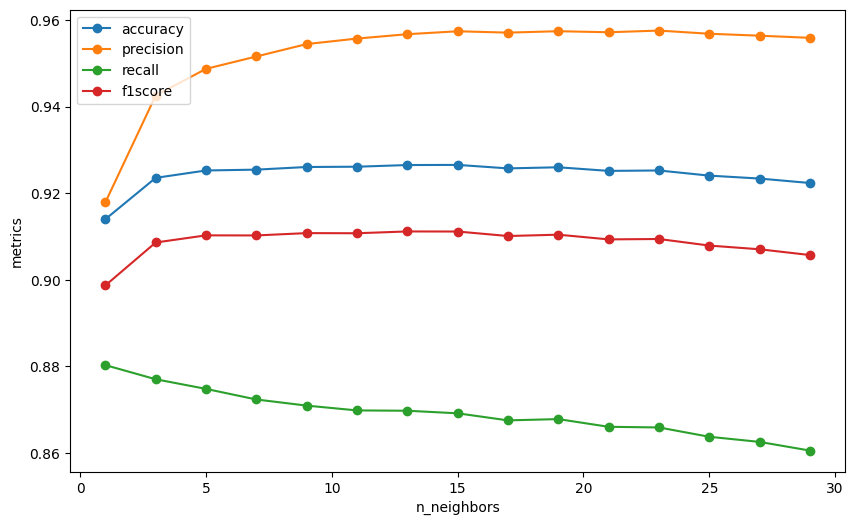

In [16]:
knn_scores.plot(x='n_neighbors', ylabel='metrics', style='o-', figsize=(10, 6));

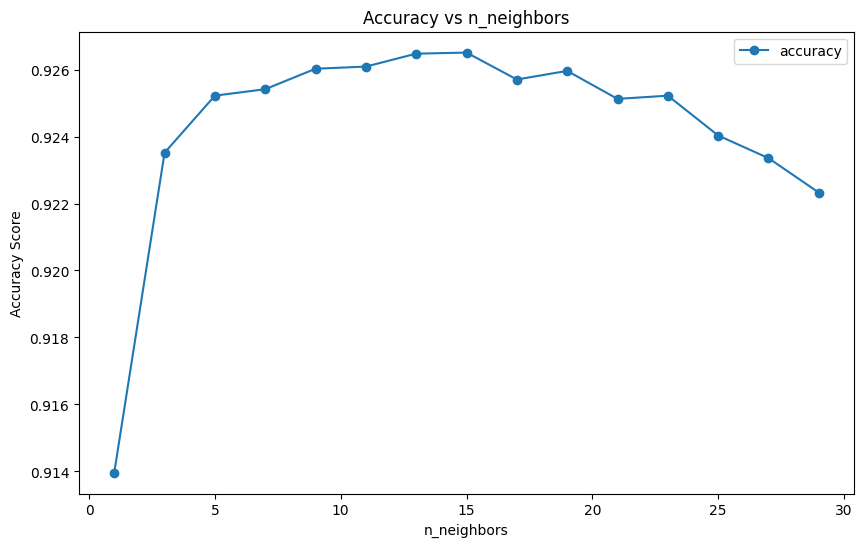

In [17]:
knn_scores.plot(x='n_neighbors', y='accuracy', ylabel='Accuracy Score', title='Accuracy vs n_neighbors' ,style='o-', figsize=(10, 6));

In [18]:
knn_max_accuracy = knn_scores.loc[knn_scores['accuracy'].idxmax()]
knn_max_accuracy

name           KNeighborsClassifier
n_neighbors                      15
accuracy                    0.92651
precision                  0.957389
recall                     0.869107
f1score                    0.911115
Name: 7, dtype: object

### 1.1.2 Performance

In [19]:
# model definition
knn = KNeighborsClassifier(n_neighbors=knn_max_accuracy['n_neighbors'])

# model fit
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15)

**Training Set**

In [23]:
train_scores = register_performance(knn, 'KNN', X_train, y_train, train_scores)
train_scores

,Algorithm,Accuracy,Precision,Recall,F1_score
0,KNN,0.934055,0.964572,0.880171,0.920441


In [25]:
confusion_matrix(y_train, knn.predict(X_train))

array([[40071,  1016],
       [ 3766, 27662]])

**Validation**

In [26]:
val_scores = register_performance(knn, 'KNN', X_val, y_val, val_scores)
val_scores

,Algorithm,Accuracy,Precision,Recall,F1_score
0,KNN,0.92651,0.957389,0.869107,0.911115


In [27]:
confusion_matrix(y_val, knn.predict(X_val))

array([[17089,   521],
       [ 1763, 11706]])

**Test**

In [28]:
test_scores = register_performance(knn, 'KNN', X_test, y_test, test_scores)
test_scores

,Algorithm,Accuracy,Precision,Recall,F1_score
0,KNN,0.924999,0.955173,0.869952,0.910573


In [29]:
confusion_matrix(y_test, knn.predict(X_test))

array([[14064,   464],
       [ 1478,  9887]])

## 1.2 Decision Tree

O algoritmo Decision Tree (árvore de decisão) implementado através da classe `DecisionTreeClassifier`, tem como objetivo segmentar o conjunto de treinamento em subconjuntos que máximizam a separação entre as classes, isso é feito buscando um par feature-valor, conhecido como "split decision", no dataset que minimiza uma medida de impureza, ou seja, que máximiza a homogêneidade dos subconjuntos resultantes. Esse processo de busca pela split decision é feito novamentos nos 2 conjuntos resultantes e é repetido até alcançar uma homogeneidade máxima ou que um dos critérios de parada seja atendido.

Parâmetros para se optimizar:

- `max_depth`: profundidade máxima da árvore, equivale ao número de split realizados pois cada split equivale a um nível da árvore.

### 1.2.1 Fine-Tuning

In [31]:
tree_scores = ml_training(
                            DecisionTreeClassifier,
                            'classification', X_train, y_train, X_val, y_val,
                            max_depth=np.arange(1, 31, 1)
                )
tree_scores

,name,max_depth,accuracy,precision,recall,f1score
0,DecisionTreeClassifier,1,0.786383,0.722013,0.824560,0.769887
1,DecisionTreeClassifier,2,0.856495,0.830024,0.841117,0.835534
2,DecisionTreeClassifier,3,0.885453,0.840398,0.908159,0.872966
3,DecisionTreeClassifier,4,0.893465,0.924169,0.821590,0.869866
4,DecisionTreeClassifier,5,0.906689,0.906531,0.874898,0.890434
5,DecisionTreeClassifier,6,0.921748,0.892748,0.931324,0.911628
6,DecisionTreeClassifier,7,0.931529,0.944083,0.895018,0.918896
7,DecisionTreeClassifier,8,0.936259,0.934954,0.916698,0.925736
8,DecisionTreeClassifier,9,0.940056,0.952440,0.906972,0.929150
9,DecisionTreeClassifier,10,0.943209,0.950292,0.916920,0.933308


In [49]:
# tree_scores.to_csv('output/classification/decision_tree.csv', index=False)
tree_scores = pd.read_csv('output/classification/decision_tree.csv')

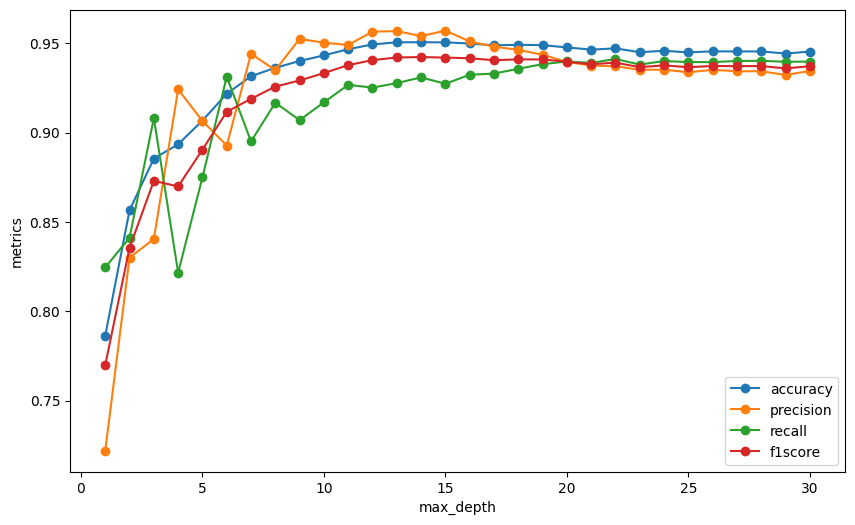

In [33]:
tree_scores.plot(x='max_depth', ylabel='metrics', style='-o', figsize=(10,6));

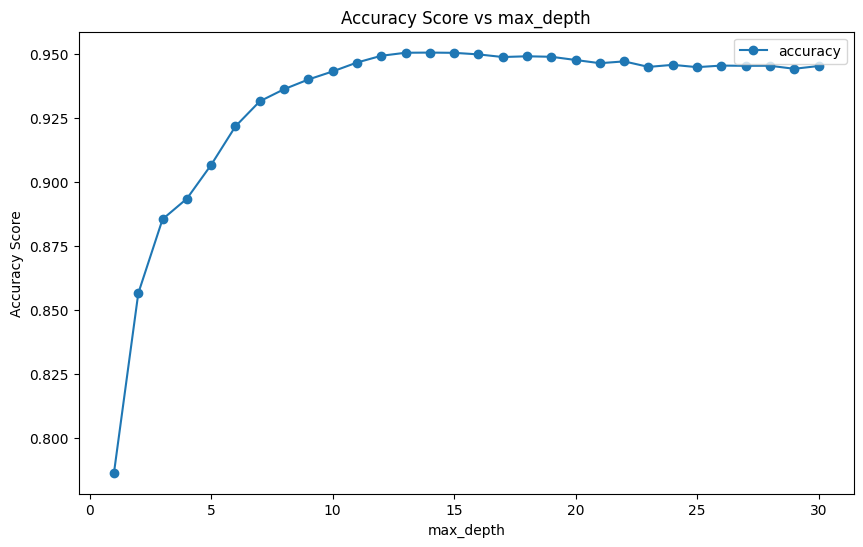

In [34]:
tree_scores.plot(x='max_depth', y='accuracy', ylabel='Accuracy Score', title='Accuracy Score vs max_depth', style='-o', figsize=(10,6));

In [35]:
tree_best_accuracy = tree_scores.loc[tree_scores['accuracy'].idxmax()]
tree_best_accuracy

name         DecisionTreeClassifier
max_depth                        14
accuracy                   0.950578
precision                  0.953968
recall                     0.930878
f1score                    0.942282
Name: 13, dtype: object

### 1.2.2 Performance

In [36]:
# model definition
tree = DecisionTreeClassifier(max_depth=tree_best_accuracy['max_depth'])

# model fit
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=14)

**training**

In [37]:
train_scores = register_performance(tree, 'Decision Tree', X_train, y_train, train_scores)
train_scores

,Algorithm,Accuracy,Precision,Recall,F1_score
0,KNN,0.934055,0.964572,0.880171,0.920441
1,Decision Tree,0.973674,0.981817,0.956981,0.969240


In [38]:
confusion_matrix(y_train, tree.predict(X_train))

array([[40530,   557],
       [ 1352, 30076]])

**Validation**

In [39]:
val_scores = register_performance(tree, 'Decision Tree', X_val, y_val, val_scores)
val_scores

,Algorithm,Accuracy,Precision,Recall,F1_score
0,KNN,0.926510,0.957389,0.869107,0.911115
1,Decision Tree,0.950706,0.954051,0.931101,0.942436


In [40]:
confusion_matrix(y_val, tree.predict(X_val))

array([[17006,   604],
       [  928, 12541]])

**Test**

In [41]:
test_scores = register_performance(tree, 'Decision Tree', X_test, y_test, test_scores)
test_scores

,Algorithm,Accuracy,Precision,Recall,F1_score
0,KNN,0.924999,0.955173,0.869952,0.910573
1,Decision Tree,0.951570,0.955574,0.933040,0.944172


In [42]:
confusion_matrix(y_test, tree.predict(X_test))

array([[14035,   493],
       [  761, 10604]])

## 1.3 Random Forest

O algoritmo Random Forest implementado pela classe `RandomForestClassifier`, utiliza várias árvores de decisão para aprender o comportamento do fenômeno e as utilizam para determinar a classe de novos pontos através de uma votação. O treinamento de cada árvore é feito em cima de um número limitado de features, de modo que cada árvore terá uma visão diferente do fenômeno sendo estudado; além disso nos treinamentos individuais é utilizado uma técnica de amostragem chamada boostrap a qual seleciona aleatóriamente os registros sendo permitido a repetição. A idéia principal do algoritmo é que cada estimador (árvore) será responsável por aprender um aspecto específico do fenômeno, e para determinar a classe final de cada nova observação utilizamos a opinião de cada uma delas através de uma votação.

Parâmetros para serem optimizados:

- `n_estimators`: número de árvores que compõem a floresta.
- `max_depth`: profundidade máxima de cada árvore. 

### 1.3.1 Fine-Tuning

In [43]:
rf_scores = ml_training(
                            RandomForestClassifier,
                            'classification',
                            X_train, y_train, X_val, y_val,
                            n_estimators=np.arange(100, 201, 10),
                            max_depth=np.arange(5, 36, 5)
            )

In [45]:
# rf_scores.to_csv('output/classification/random_forest.csv', index=False)
rf_scores = pd.read_csv('output/classification/random_forest.csv')

rf_scores

,name,n_estimators,max_depth,accuracy,precision,recall,f1score
0,RandomForestClassifier,100,5,0.917468,0.914916,0.892568,0.903604
1,RandomForestClassifier,100,10,0.945816,0.944348,0.929765,0.937000
2,RandomForestClassifier,100,15,0.959619,0.965828,0.940085,0.952782
3,RandomForestClassifier,100,20,0.961453,0.969254,0.940901,0.954867
4,RandomForestClassifier,100,25,0.962418,0.970186,0.942238,0.956008
...,...,...,...,...,...,...,...
72,RandomForestClassifier,200,15,0.959876,0.964927,0.941644,0.953143
73,RandomForestClassifier,200,20,0.961904,0.969862,0.941347,0.955391
74,RandomForestClassifier,200,25,0.962483,0.971705,0.940827,0.956017
75,RandomForestClassifier,200,30,0.962547,0.970698,0.942015,0.956142


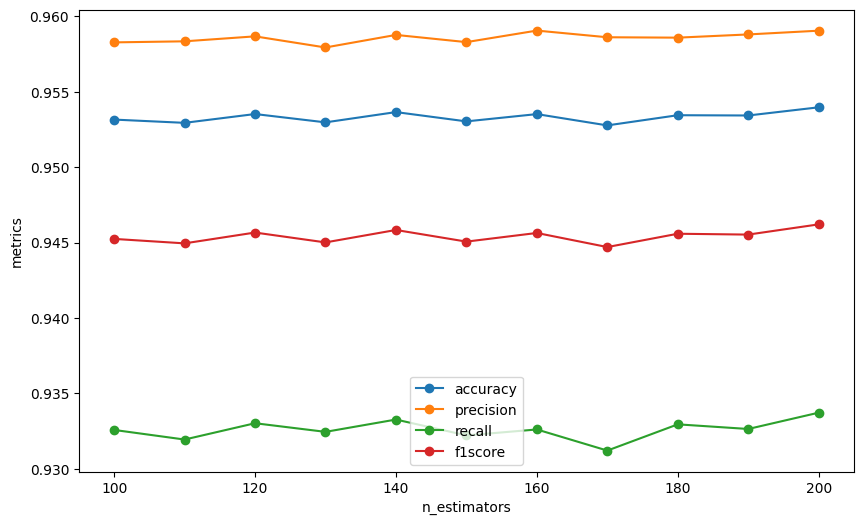

In [50]:
rf_scores.drop('max_depth', axis=1).groupby('n_estimators').mean(numeric_only=True).reset_index().plot(x='n_estimators', ylabel='metrics', style='o-', figsize=(10, 6));

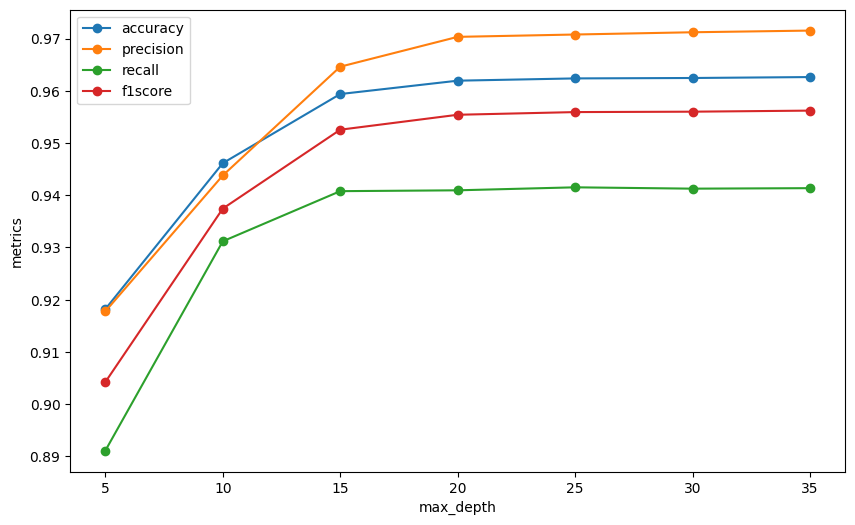

In [51]:
rf_scores.drop('n_estimators', axis=1).groupby('max_depth').mean(numeric_only=True).reset_index().plot(x='max_depth', ylabel='metrics', style='o-', figsize=(10, 6));

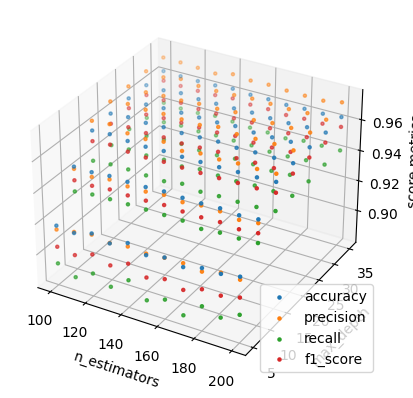

In [52]:
ax = plt.figure().add_subplot(projection='3d')

ax.scatter(xs=rf_scores['n_estimators'], ys=rf_scores['max_depth'], zs=rf_scores['accuracy'],  marker='.', label='accuracy')
ax.scatter(xs=rf_scores['n_estimators'], ys=rf_scores['max_depth'], zs=rf_scores['precision'], marker='.', label='precision')
ax.scatter(xs=rf_scores['n_estimators'], ys=rf_scores['max_depth'], zs=rf_scores['recall'],    marker='.', label='recall')
ax.scatter(xs=rf_scores['n_estimators'], ys=rf_scores['max_depth'], zs=rf_scores['f1score'],   marker='.', label='f1_score')

ax.legend()
ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_zlabel('score metrics');

In [54]:
rf_max_accuracy = rf_scores.loc[rf_scores['accuracy'].idxmax()]
rf_max_accuracy

name            RandomForestClassifier
n_estimators                       200
max_depth                           35
accuracy                      0.963351
precision                     0.972776
recall                        0.941792
f1score                       0.957033
Name: 76, dtype: object

### 1.3.2 Performance

In [55]:
# model definition
rf = RandomForestClassifier(n_estimators=rf_max_accuracy['n_estimators'], max_depth=rf_max_accuracy['max_depth'])

# model fit
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=35, n_estimators=200)

**Training**

In [56]:
train_scores = register_performance(rf, 'Random Forest', X_train, y_train, train_scores)
train_scores

,Algorithm,Accuracy,Precision,Recall,F1_score
0,KNN,0.934055,0.964572,0.880171,0.920441
1,Decision Tree,0.973674,0.981817,0.956981,0.969240
2,Random Forest,1.000000,1.000000,1.000000,1.000000


In [57]:
confusion_matrix(y_train, rf.predict(X_train))

array([[41087,     0],
       [    0, 31428]])

**Validation**

In [58]:
val_scores = register_performance(rf, 'Random Forest', X_val, y_val, val_scores)
val_scores

,Algorithm,Accuracy,Precision,Recall,F1_score
0,KNN,0.926510,0.957389,0.869107,0.911115
1,Decision Tree,0.950706,0.954051,0.931101,0.942436
2,Random Forest,0.962193,0.971468,0.940382,0.955672


In [59]:
confusion_matrix(y_val, rf.predict(X_val))

array([[17238,   372],
       [  803, 12666]])

**Test**

In [60]:
test_scores = register_performance(rf, 'Random Forest', X_test, y_test, test_scores)
test_scores

,Algorithm,Accuracy,Precision,Recall,F1_score
0,KNN,0.924999,0.955173,0.869952,0.910573
1,Decision Tree,0.951570,0.955574,0.933040,0.944172
2,Random Forest,0.961766,0.970351,0.941663,0.955792


In [61]:
confusion_matrix(y_test, rf.predict(X_test))

array([[14201,   327],
       [  663, 10702]])

## 1.4 Logistic Regression

O algoritmo Logistic Regression implementado pela classe `LogisticRegression`, determina, a partir dos exemplos vistos no durante o treinamento, a probabilidade das novas observações pertencem a uma das classes vistas. Essas probabilidades são então utilizadas, junto a um threshold (probabilidade mínima que um ponto precisa atingir para pertencer a uma classe), para determinar qual classe cada novo ponto pertence.

Geralmente o threshold é definido em relação a classe positiva, ou seja, se determinado ponto atingir uma probalidade de pertencer a classe positiva maior que o threshold, ele receberá o rótulo positivo, e caso contrário receberá o rótulo negativo. Resumindo, sendo $\hat{y}$ a probabilidade calculada e $\text{th}$ o threshold escolhido, temos:

- Se $\;\hat{y} \ge \text{th} \; \Rightarrow \;$ classe positiva
- Se $\;\hat{y} \lt \text{th} \; \Rightarrow \;$ classe negativa

Parâmetros para serem optimizados:

- `C`: Define a força da regularização; quanto mais próximo de 0, maior será a força da regularização.

- `solver`: Algoritmo utilizado para minimizar a função de custo.

- `max_iter`: Número máximo de iterações permitido ao algoritmo 'solver' na hora de procurar um ponto de convergência (valor mínimo) da função de custo.

### 1.4.1 Fine-Tuning

In [63]:
lr_scores = ml_training(
                            LogisticRegression,
                            'classification',
                            X_train, y_train, X_val, y_val,
                            C=np.linspace(0.1, 1, 10),
                            solver=['lbfgs', 'liblinear'],
                            max_iter=[1000, 1500, 2000]
            )

In [65]:
# lr_scores.to_csv('output/classification/logistic_regression.csv', index=False)
lr_scores = pd.read_csv('output/classification/logistic_regression.csv')

lr_scores

,name,C,solver,max_iter,accuracy,precision,recall,f1score
0,LogisticRegression,0.1,lbfgs,1000,0.873999,0.869327,0.834732,0.851678
1,LogisticRegression,0.1,lbfgs,1500,0.873999,0.869327,0.834732,0.851678
2,LogisticRegression,0.1,lbfgs,2000,0.873999,0.869327,0.834732,0.851678
3,LogisticRegression,0.1,liblinear,1000,0.873902,0.868897,0.835029,0.851626
4,LogisticRegression,0.1,liblinear,1500,0.873902,0.868897,0.835029,0.851626
5,LogisticRegression,0.1,liblinear,2000,0.873902,0.868897,0.835029,0.851626
6,LogisticRegression,0.2,lbfgs,1000,0.873870,0.868830,0.835029,0.851594
7,LogisticRegression,0.2,lbfgs,1500,0.873870,0.868830,0.835029,0.851594
8,LogisticRegression,0.2,lbfgs,2000,0.873870,0.868830,0.835029,0.851594
9,LogisticRegression,0.2,liblinear,1000,0.874095,0.869015,0.835400,0.851876


In [66]:
aux_lr_df = lr_scores.groupby(['C', 'solver', 'max_iter'], as_index=False).mean(numeric_only=True).pivot(index='C', columns=['solver', 'max_iter'])
aux_lr_df

accuracy                                                    \
solver       lbfgs                     liblinear                       
max_iter      1000      1500      2000      1000      1500      2000   
C                                                                      
0.1       0.873999  0.873999  0.873999  0.873902  0.873902  0.873902   
0.2       0.873870  0.873870  0.873870  0.874095  0.874095  0.874095   
0.3       0.873805  0.873805  0.873805  0.874095  0.874095  0.874095   
0.4       0.873773  0.873773  0.873773  0.873966  0.873966  0.873966   
0.5       0.873773  0.873773  0.873773  0.873934  0.873934  0.873934   
0.6       0.873902  0.873902  0.873902  0.873902  0.873902  0.873902   
0.7       0.873870  0.873870  0.873870  0.873934  0.873934  0.873934   
0.8       0.873966  0.873966  0.873966  0.873966  0.873966  0.873966   
0.9       0.873934  0.873934  0.873934  0.873966  0.873966  0.873966   
1.0       0.873934  0.873934  0.873934  0.873902  0.873902  0.873902   

         precision                                ...    recall            \
solver       lbfgs                     liblinear  ...     lbfgs liblinear   
max_iter      1000      1500      2000      1000  ...      2000      1000   
C                                                 ...                       
0.1       0.869327  0.869327  0.869327  0.868897  ...  0.834732  0.835029   
0.2       0.868830  0.868830  0.868830  0.869015  ...  0.835029  0.835400   
0.3       0.868639  0.868639  0.868639  0.869072  ...  0.835103  0.835326   
0.4       0.868571  0.868571  0.868571  0.868860  ...  0.835103  0.835251   
0.5       0.868628  0.868628  0.868628  0.868907  ...  0.835029  0.835103   
0.6       0.868783  0.868783  0.868783  0.868783  ...  0.835177  0.835177   
0.7       0.868773  0.868773  0.868773  0.868850  ...  0.835103  0.835177   
0.8       0.868917  0.868917  0.868917  0.868974  ...  0.835177  0.835103   
0.9       0.868793  0.868793  0.868793  0.868917  ...  0.835251  0.835177   
1.0       0.868850  0.868850  0.868850  0.868783  ...  0.835177  0.835177   

                               f1score                                \
solver                           lbfgs                     liblinear   
max_iter      1500      2000      1000      1500      2000      1000   
C                                                                      
0.1       0.835029  0.835029  0.851678  0.851678  0.851678  0.851626   
0.2       0.835400  0.835400  0.851594  0.851594  0.851594  0.851876   
0.3       0.835326  0.835326  0.851541  0.851541  0.851541  0.851864   
0.4       0.835251  0.835251  0.851508  0.851508  0.851508  0.851724   
0.5       0.835103  0.835103  0.851497  0.851497  0.851497  0.851670   
0.6       0.835177  0.835177  0.851649  0.851649  0.851649  0.851649   
0.7       0.835177  0.835177  0.851605  0.851605  0.851605  0.851681   
0.8       0.835103  0.835103  0.851713  0.851713  0.851713  0.851702   
0.9       0.835177  0.835177  0.851692  0.851692  0.851692  0.851713   
1.0       0.835177  0.835177  0.851681  0.851681  0.851681  0.851649   

                              
solver                        
max_iter      1500      2000  
C                             
0.1       0.851626  0.851626  
0.2       0.851876  0.851876  
0.3       0.851864  0.851864  
0.4       0.851724  0.851724  
0.5       0.851670  0.851670  
0.6       0.851649  0.851649  
0.7       0.851681  0.851681  
0.8       0.851702  0.851702  
0.9       0.851713  0.851713  
1.0       0.851649  0.851649  

[10 rows x 24 columns]

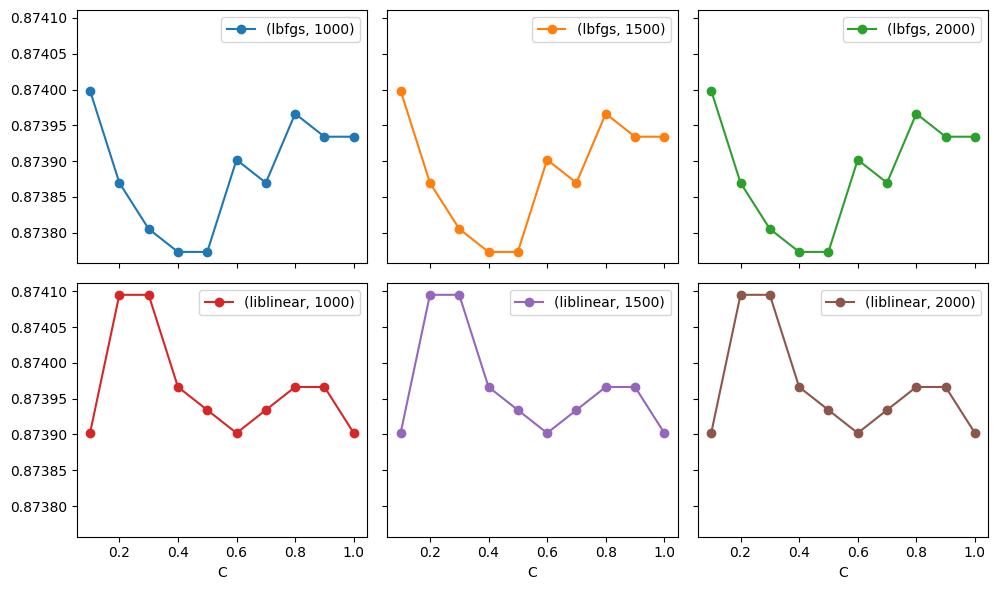

In [67]:
aux_lr_df.loc[:, 'accuracy'].plot(subplots=True, layout=(2,3), sharey=True, figsize=(10, 6), style='o-');
plt.tight_layout()

In [68]:
lr_max_accuracy = lr_scores.loc[lr_scores['accuracy'].idxmax()]
lr_max_accuracy

name         LogisticRegression
C                           0.2
solver                liblinear
max_iter                   1000
accuracy               0.874095
precision              0.869015
recall                   0.8354
f1score                0.851876
Name: 9, dtype: object

### 1.4.2 Performance

In [69]:
# model definition
lr = LogisticRegression(C=lr_max_accuracy['C'], solver=lr_max_accuracy['solver'], max_iter=lr_max_accuracy['max_iter'])

# model fit
lr.fit(X_train, y_train)

LogisticRegression(C=0.2, max_iter=1000, solver='liblinear')

**Training**

In [70]:
train_scores = register_performance(lr, 'Logistic Regression', X_train, y_train, train_scores)
train_scores

,Algorithm,Accuracy,Precision,Recall,F1_score
0,KNN,0.934055,0.964572,0.880171,0.920441
1,Decision Tree,0.973674,0.981817,0.956981,0.969240
2,Random Forest,1.000000,1.000000,1.000000,1.000000
3,Logistic Regression,0.875115,0.870152,0.836706,0.853101


In [71]:
confusion_matrix(y_train, lr.predict(X_train))

array([[37163,  3924],
       [ 5132, 26296]])

**Validation**

In [72]:
val_scores = register_performance(lr, 'Logistic Regression', X_val, y_val, val_scores)
val_scores

,Algorithm,Accuracy,Precision,Recall,F1_score
0,KNN,0.926510,0.957389,0.869107,0.911115
1,Decision Tree,0.950706,0.954051,0.931101,0.942436
2,Random Forest,0.962193,0.971468,0.940382,0.955672
3,Logistic Regression,0.874095,0.869015,0.835400,0.851876


In [73]:
confusion_matrix(y_val, lr.predict(X_val))

array([[15914,  1696],
       [ 2217, 11252]])

**Test**

In [74]:
test_scores = register_performance(lr, 'Logistic Regression', X_test, y_test, test_scores)
test_scores

,Algorithm,Accuracy,Precision,Recall,F1_score
0,KNN,0.924999,0.955173,0.869952,0.910573
1,Decision Tree,0.951570,0.955574,0.933040,0.944172
2,Random Forest,0.961766,0.970351,0.941663,0.955792
3,Logistic Regression,0.871703,0.868573,0.833876,0.850871


In [75]:
confusion_matrix(y_test, lr.predict(X_test))

array([[13094,  1434],
       [ 1888,  9477]])

# 2.0 Resumo

In [77]:
# train_scores.to_csv('output/classification/train_scores.csv', index=False)
train_scores

,Algorithm,Accuracy,Precision,Recall,F1_score
0,KNN,0.934055,0.964572,0.880171,0.920441
1,Decision Tree,0.973674,0.981817,0.956981,0.969240
2,Random Forest,1.000000,1.000000,1.000000,1.000000
3,Logistic Regression,0.875115,0.870152,0.836706,0.853101


In [78]:
# val_scores.to_csv('output/classification/val_scores.csv', index=False)
val_scores

,Algorithm,Accuracy,Precision,Recall,F1_score
0,KNN,0.926510,0.957389,0.869107,0.911115
1,Decision Tree,0.950706,0.954051,0.931101,0.942436
2,Random Forest,0.962193,0.971468,0.940382,0.955672
3,Logistic Regression,0.874095,0.869015,0.835400,0.851876


In [79]:
# test_scores.to_csv('output/classification/test_scores.csv', index=False)
test_scores

,Algorithm,Accuracy,Precision,Recall,F1_score
0,KNN,0.924999,0.955173,0.869952,0.910573
1,Decision Tree,0.951570,0.955574,0.933040,0.944172
2,Random Forest,0.961766,0.970351,0.941663,0.955792
3,Logistic Regression,0.871703,0.868573,0.833876,0.850871
